In [3]:
import math
import pandas_datareader as reader
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,LSTM, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt

/usr/local/lib/python3.7/site-packages/pandas_datareader/compat/__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


In [4]:
df=pd.read_csv('HSI2010.csv',thousands=',')
df['Date']=pd.to_datetime(df['Date'])
df['Price']=df['Price'].astype(float)
df['Low']=df['Low'].astype(float)
df['High']=df['High'].astype(float)
df.set_index('Date',inplace=True)
df=df.iloc[::-1]
df=df.dropna(subset=['High','Price','Low'])
df.shape


(2677, 6)

In [5]:
df[310:]

,Price,Open,High,Low,Vol.,Change %
Date,,,,,,
2011-01-14,24351.5,24283.5,24351.5,24199.5,-,0.35%
2011-01-17,24211.5,24373.5,24392.5,24097.5,-,-0.57%
2011-01-18,24204.5,24194.5,24415.5,24091.5,-,-0.03%
2011-01-19,24384.5,24344.5,24460.5,24266.5,-,0.74%
2011-01-20,24006.5,24254.5,24254.5,23966.5,-,-1.55%
...,...,...,...,...,...,...
2020-06-15,23702.0,24242.0,24384.0,23555.0,189.28K,-2.11%
2020-06-16,24355.0,23710.0,24475.0,23675.0,159.83K,2.76%
2020-06-17,24402.0,24360.0,24632.0,24076.0,159.14K,0.19%


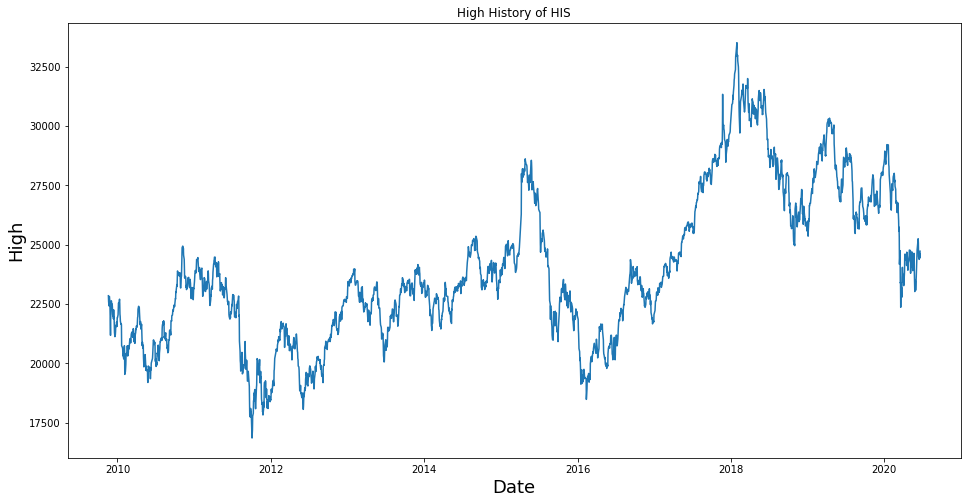

In [6]:
plt.figure(figsize=(16,8))
plt.title("High History of HIS")
plt.plot(df['High'])
plt.xlabel('Date',fontsize=18)
plt.ylabel('High',fontsize=18)
plt.show()

In [7]:
data=df.filter(['High'])
dataset=data.values

scaler=MinMaxScaler(feature_range=(0,1))
dataset=scaler.fit_transform(dataset)

train_len=math.ceil(len(dataset)*.80)

x_train=dataset[0:train_len,:]
x_test=dataset[train_len-60: , :]

In [8]:
xt_train=[]
yt_train=[]

for i in range(60, len(x_train)):
    xt_train.append(x_train[i-60:i,0])
    yt_train.append(x_train[i,0])
    
xt_train,yt_train=np.array(xt_train),np.array(yt_train)
xt_train=np.reshape(xt_train,(xt_train.shape[0],xt_train.shape[1],x_train.shape[1]))
print(xt_train.shape)
print(yt_train.shape)

(2082, 60, 1)
(2082,)


In [9]:
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(xt_train.shape[1],1)))
model.add(Dropout(0.2))
model.add(LSTM(50,return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(50,return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))

model.add(Dense(1,activation='relu'))

callback= EarlyStopping(monitor='loss',patience=3,verbose=1,mode='min')

In [12]:
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(xt_train, yt_train,batch_size=32,epochs=130)

Epoch 1/130
66/66 [==============================] - 4s 67ms/step - loss: 0.0036
Epoch 2/130
66/66 [==============================] - 4s 67ms/step - loss: 0.0026
Epoch 3/130
66/66 [==============================] - 4s 67ms/step - loss: 0.0024
Epoch 4/130
17/66 [======>.......................] - ETA: 3s - loss: 0.0021

KeyboardInterrupt: 

In [94]:
xt_test=[]
yt_test=dataset[train_len: ,:]

for i in range(60,len(x_test)):
    xt_test.append(x_test[i-60:i,0])
    
xt_test=np.array(xt_test)
xt_test=np.reshape(xt_test,(xt_test.shape[0],xt_test.shape[1],1))

In [95]:
prediction=model.predict(xt_test)
rmse=np.sqrt(np.mean(prediction-yt_test)**2)
prediction=scaler.inverse_transform(prediction)

print(rmse)

0.0012882455895297461


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


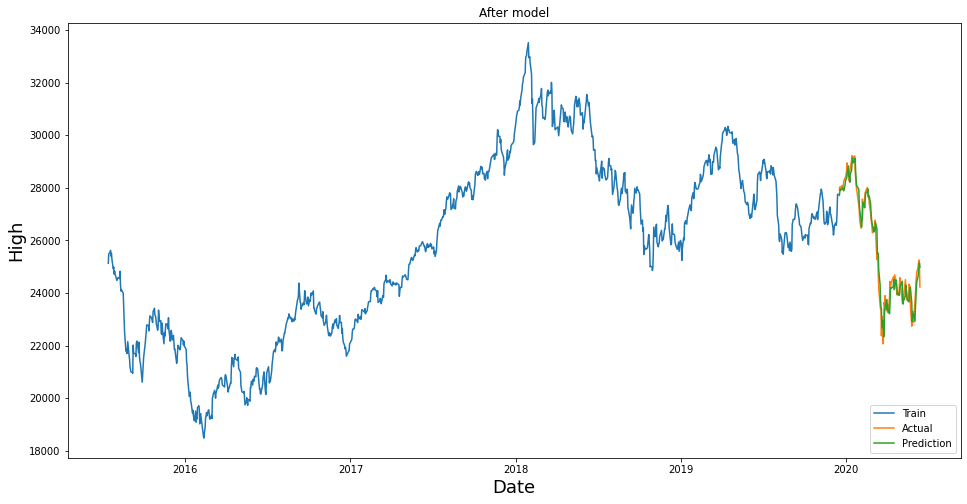

In [100]:
train=df[:train_len]
valid=df[train_len:]
valid['pre']=prediction

plt.figure(figsize=(16,8))
plt.title('After model')
plt.xlabel('Date',fontsize=18)
plt.ylabel('High',fontsize=18)
plt.plot(train['High'])
plt.plot(valid[['High','pre']])
plt.legend(['Train','Actual','Prediction'],loc='lower right')
plt.show()

In [101]:
valid

,Open,Bid,Ask,Last Traded,High,Low,Volume,Prev. Day Settlement Price,Net Change,Prev. Day Open Interest,pre
Date,,,,,,,,,,,
2019-12-17,27613.0,NaN,NaN,NaN,27922.0,27563.0,155789.0,27829.0,249.0,123141.0,27708.093750
2019-12-18,27903.0,NaN,NaN,NaN,28032.0,27786.0,139035.0,27917.0,88.0,123465.0,27844.650391
2019-12-19,27909.0,NaN,NaN,NaN,27976.0,27692.0,120309.0,27804.0,-113.0,124490.0,27949.451172
2019-12-20,27798.0,NaN,NaN,NaN,28014.0,27755.0,147631.0,27940.0,136.0,122869.0,27919.173828
2019-12-23,28050.0,NaN,NaN,NaN,28080.0,27846.0,170243.0,27856.0,-84.0,118981.0,27944.503906
...,...,...,...,...,...,...,...,...,...,...,...
2020-06-08,24940.0,NaN,NaN,NaN,24984.0,24597.0,114674.0,24745.0,48.0,125747.0,24623.671875
2020-06-09,24780.0,NaN,NaN,NaN,25183.0,24722.0,122610.0,24867.0,122.0,124007.0,24830.083984
2020-06-10,24990.0,NaN,NaN,NaN,25255.0,24885.0,121625.0,25017.0,150.0,122388.0,25037.134766


In [102]:
with open('Result.txt','wt') as f:
    print(valid, file=f)